# Kernels
In machine learning, kernel methods are a class of algorithms for pattern analysis, whose best known member is the support vector machine (SVM). The general task of pattern analysis is to find and study general types of relations (for example clusters, rankings, principal components, correlations, classifications) in datasets. For many algorithms that solve these tasks, the data in raw representation have to be explicitly transformed into feature vector representations via a user-specified feature map: in contrast, kernel methods require only a user-specified kernel, i.e., a similarity function over pairs of data points in raw representation.
Kernel methods owe their name to the use of kernel functions, which enable them to operate in a high-dimensional, implicit feature space without ever computing the coordinates of the data in that space, but rather by simply computing the inner products between the images of all pairs of data in the feature space. This operation is often computationally cheaper than the explicit computation of the coordinates. This approach is called the "kernel trick".
Kernel functions have been introduced for sequence data, graphs, text, images, as well as vectors.

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

## Objective 
Maximaize $f2$ score, also try $f=0.5$


In [2]:
######################### Load dataset and split into X and y #######################

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

print(X.shape)
print('The portion of ' + cancer.target_names[1] + ' cancer: ' + str(round(y.sum()/len(y) * 100, 4)) + '%.')
# Rest is malignant
# The dataset is quite balanced.
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html ########### 这个dataset的用法

(569, 30)
The portion of benign cancer: 62.7417%.


In [5]:
######################### Convert to df and get some info#########################
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
#df.info()
#df.describe()

# Split into train and test set and normalize data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2) #, random_state = 0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

fbeta_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

$f1$ and $f2$ scores: https://en.wikipedia.org/wiki/F1_score

$F_\beta=(1+\beta^2)\cdot \frac{precision  \cdot  recall}{\beta^2 \cdot precision + recall} = \frac{1+\beta^2}{\frac{1}{precision}+\frac{\beta^2}{recall}}$

Now $\beta=2$ for $f2$, the score weighs recall higher than precision by placing more emphasis on false negatives. In this case, we want to be more confident of predicting benign cancer more precisely and want to diagnose less a benign cancer as malignant, i.e. to avoid false negative of benign cancer.

We will consider $f=0.5$ as well:
If we want to avoid false positives, we need to maximize Precision or put more weights on precision in the $f_\beta$ score if we want to balance recall and precision as well. 
Therefore, as a second objective, we pick $\beta = 0.5$ to get $f0.5$ and use it as our optimization object for this question.

In [9]:
######################### 用f2来作为 Performance Metrics #########################
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)



# Here for question b: make f05 a valid validation
def f05_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 0.5, pos_label = 0, average = 'binary')

f05 = make_scorer(f05_scorer, greater_is_better = True)

We first make the graphs to illustrate the relationships between hyperparameters and f2 and f0.5 scores for polynomial and rbf kernels. 

/Users/fanjia_imac27/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=degree, param_range=[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/fanjia_imac27/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=degree, param_range=[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/fanjia_imac27/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=C, param_range=[  0.5   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   12.
  14.   16.   1

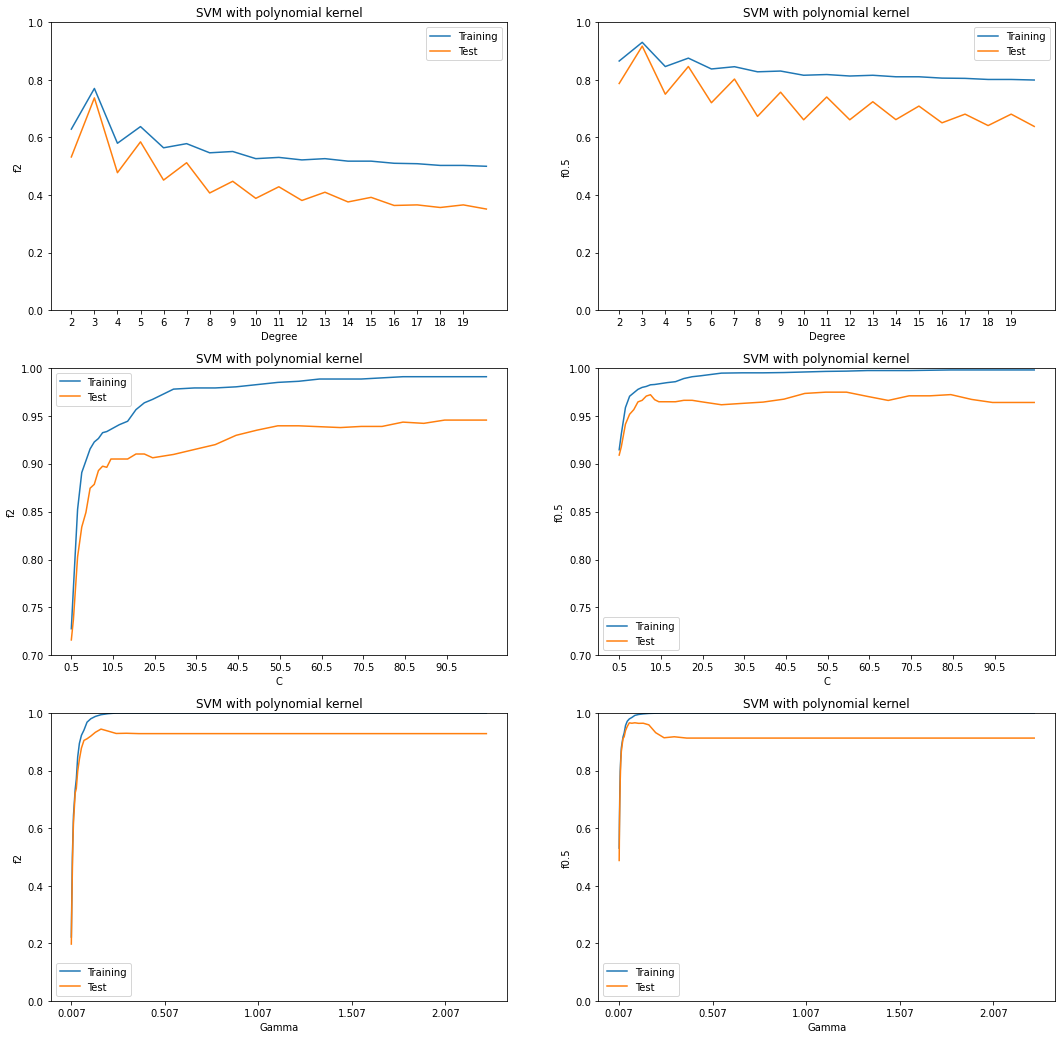

In [15]:
######################### SVM (先用SVC) with polynomial kernel #########################
# for score = f2 and f0.5
# hyperparameters gamma, C and degree, degree is the main one
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

def plot_poly_curve(gammas = 'auto', Cs = 1, degrees = 3, scoring = f2): #用F2来做scoring metrics
    
    num_splits = 5 ###########用于下面对df拆分
    kfold = KFold(n_splits = 5) # ,random_state = 0) ###########用于cross validation
    
    ###################### 下面正式call Polynomial kernel #######################    
    
    ######################【1】对polynomial kernel的 degree 进行观察
    if type(degrees) == np.ndarray: 
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, C = Cs) ########### C fixed = 1
        num_values = len(degrees) ########### 这里取用degrees的长度
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, "degree", degrees,                                                      cv=kfold, scoring = scoring)
        xlabel = 'Degree'
        xtick = np.arange(degrees.min(), degrees.max(), 1)
        Xs = degrees  ########### 这里取用一个degrees的 ndarray
        ylim = [0, 1]

    ######################【2】对polynomial的 C 进行观察
    elif type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, degree = degrees)###### degree fixed = 3
        num_values = len(Cs) ########### 这里取用C的长度
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                      "C", Cs, cv=kfold, scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs ########### 这里取用一个C的 ndarray
        ylim = [0.7, 1]

    ######################【3】对polynomial的 gamma 进行观察
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', degree = degrees, C = Cs) ###### C fixed = 1
        num_values = len(gammas) ########### 这里取用 gamma 的长度
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                      "gamma", gammas, cv=kfold, scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas ########### 这里取用一个 gamma 的 ndarray
        ylim = [0, 1]
    else:
        raise TypeError



    train_scores_poly = pd.DataFrame(data = train_scores,  ########### Train组的scores
                                     index = np.arange(0, num_values), 
                                     columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores,  ########### Test组的scores
                                     index = np.arange(0, num_values), 
                                     columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with polynomial kernel')
    plt.legend()

    
plt.figure(figsize = (18, 18))
degrees = np.arange(2, 21, 1) ############ 定义 degrees: choose/scan more systematically 
Cs = np.append(np.array([0.5]),  ############ 定义 C: choose/scan more systematically
               np.append(np.append(np.arange(1, 10, 1), # 就是1-100用三个间隔产生的array
                                   np.arange(10, 20, 2)), 
                                   np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2)) ############ 定义 gamma: choose/scan more systematically 

plt.subplot(3, 2, 1)
plot_poly_curve(degrees = degrees)
plt.subplot(3, 2, 2)
plot_poly_curve(degrees = degrees, scoring = f05)
plt.subplot(3, 2, 3)
plot_poly_curve(Cs = Cs)
plt.subplot(3, 2, 4)
plot_poly_curve(Cs = Cs, scoring = f05)
plt.subplot(3, 2, 5)
plot_poly_curve(gammas = gammas)
plt.subplot(3, 2, 6)
plot_poly_curve(gammas = gammas, scoring = f05)

plt.show()

/Users/fanjia_imac27/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=C, param_range=[  0.5   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   12.
  14.   16.   18.   20.   25.   30.   35.   40.   45.   50.   55.   60.
  65.   70.   75.   80.   85.   90.   95.  100. ] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/fanjia_imac27/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=C, param_range=[  0.5   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   12.
  14.   16.   18.   20.   25.   30.   35.   40.   45.   50.   55.   60.
  65.   70.   75.   80.   85.   90.   95.  100. ] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} 

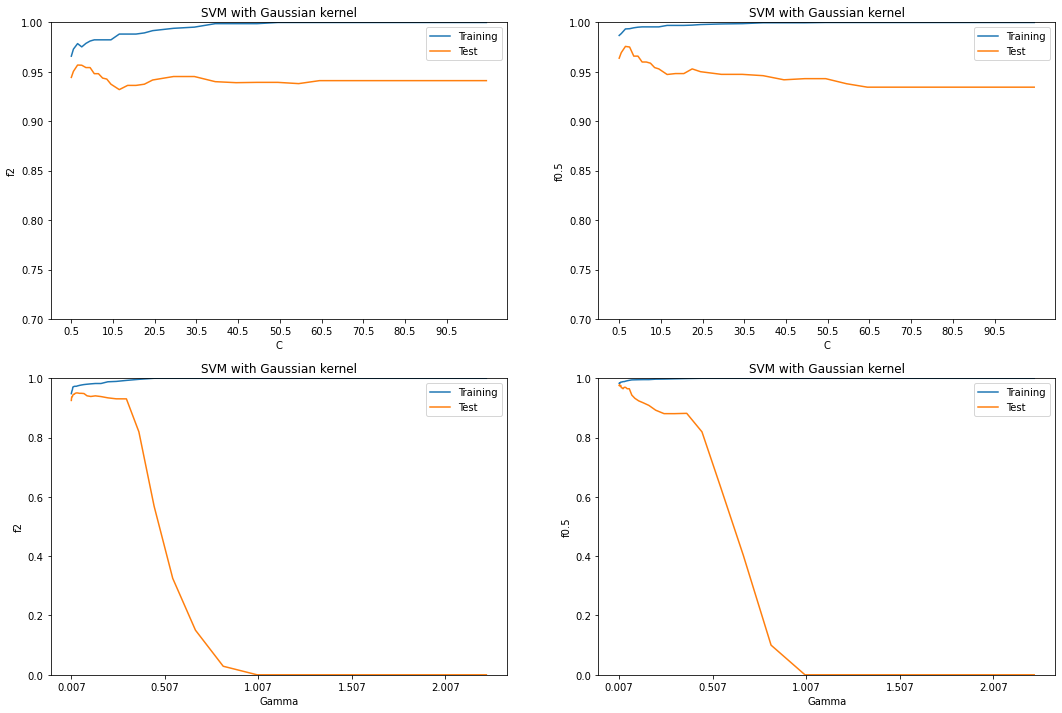

In [18]:
######################### SVM (先用SVC) with Gaussian kernel #########################
# The two functions can actually be integrated.
def plot_rbf_curve(gammas = 'auto', Cs = 1, scoring = f2): #用F2来做scoring metrics
    
    num_splits = 5 ###########用于下面对df拆分
    kfold = KFold(n_splits = 5) # ,random_state = 0) ###########用于cross validation
    
    ###################### 下面正式call Gaussian kernel #######################
    
    ######################【1】对Gaussian的 C 进行观察
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', gamma = gammas) ###### gamma fixed = 'auto'
        num_values = len(Cs) ########### 这里取用C的长度
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  "C", Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs ########### 这里取用一个C的 ndarray
        ylim = [0.7, 1]

    ######################【2】对Gaussian的 gamma 进行观察
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', C = Cs) ###### C fixed = 1
        num_values = len(gammas) ########### 这里取用 gamma 的长度
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  "gamma", gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas ########### 这里取用一个 gamma 的 ndarray
        ylim = [0, 1]

    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, ########### Train组的scores
                                     index = np.arange(0, num_values), 
                                     columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, ########### Test组的scores
                                     index = np.arange(0, num_values), 
                                     columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with Gaussian kernel')
    plt.legend()

    
plt.figure(figsize = (18, 12))

Cs = np.append(np.array([0.5]), ############ 定义 C: choose/scan more systematically ############
               np.append(np.append(np.arange(1, 10, 1), 
                                   np.arange(10, 20, 2)), 
                                   np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2)) ############ 定义 gamma: choose/scan more systematically ####

plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = f05)

plt.show()

The rbf kernel generally performs much better in different hyperparameter combos, note that the y-axis in graphs for rbf kernel are ranging from 0.7 to 1, while that for polynomial kernel are ranging from 0 to 1. For the polynomial kernel, the higher the polynomial degree, the lower the scores. We can see sawtooth on the curve when degree changes, this might be that the tail directions of decision boundry will be the same for kernels using even order of degrees. 

For both kernels, the models perform not so well when C is very small (high degree of regularization), while a larger C (less regularization) will introduce overfitting: high score in training data but low in test data. Besides, the results generally get better with increasing gamma at the very beginning, all else equal, but become dramatically worse when gamma keeps increasing. This can be explained and illustrated under https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html. 

"Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors." Thus the classifier becomes extremly overfitted when gamma is large.

# Optimal hyperparameters
We use the GridSearchCV function to find the optimal hyperparameters in this part. In the Grid Search space, if gamma = 'scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma. Now training data is normalized, so gamma will be close to 1 / 30 = 0.0333 (depends on cross validation set) when gamma is defined by 'scale'. If gamma = ‘auto’, it uses 1 / n_features. Hence there is almost no difference between those two. We just use 1 / n_features and other specific values.

In [24]:
######################### GridRearch 对所有kernels #########################

start = time.time()

param_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/X_train.shape[1], 0.01, 0.1, 1, 10],#相当于gamma=‘auto’, uses 1/n_features
              'degree' : [2, 3, 4, 5, 7, 10]}              

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : 'recall',
           'f1' : 'f1', 
           'f2' : f2,
           'f0.5' : f05}

svm_svc = svm.SVC() #random_state = 0)
CV_svm = GridSearchCV(estimator = svm_svc, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')
CV_svm.fit(X_train, y_train)


time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  31.930031776428223


In [27]:
######################### 用results df来记录下来 Gridsearch 的结果 #########################

params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)
display(results)

,C,degree,gamma,kernel,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_f2,std_test_f2,mean_test_f0.5,std_test_f0.5
0,0.001,2,0.033333,linear,0.925275,0.028991,0.894887,0.038200,1.000000,0.000000,0.944107,0.020903,0.832534,0.067005,0.950908,0.021124
1,0.001,2,0.033333,poly,0.624176,0.004396,0.624176,0.004396,1.000000,0.000000,0.768597,0.003346,0.000000,0.000000,0.000000,0.000000
2,0.001,2,0.033333,rbf,0.624176,0.004396,0.624176,0.004396,1.000000,0.000000,0.768597,0.003346,0.000000,0.000000,0.000000,0.000000
3,0.001,2,0.033333,sigmoid,0.624176,0.004396,0.624176,0.004396,1.000000,0.000000,0.768597,0.003346,0.000000,0.000000,0.000000,0.000000
4,0.001,2,0.010000,linear,0.925275,0.028991,0.894887,0.038200,1.000000,0.000000,0.944107,0.020903,0.832534,0.067005,0.950908,0.021124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,100.000,10,1.000000,sigmoid,0.883516,0.014906,0.889724,0.023075,0.929511,0.011597,0.908913,0.010228,0.818784,0.039804,0.858967,0.013843
956,100.000,10,10.000000,linear,0.953846,0.026374,0.968590,0.025661,0.957644,0.028756,0.962780,0.021174,0.943694,0.037883,0.935118,0.038846
957,100.000,10,10.000000,poly,0.714286,0.036776,0.780995,0.041968,0.757080,0.019959,0.768373,0.025545,0.635508,0.073777,0.617465,0.048027
958,100.000,10,10.000000,rbf,0.624176,0.004396,0.624176,0.004396,1.000000,0.000000,0.768597,0.003346,0.000000,0.000000,0.000000,0.000000


In [28]:
results.loc[results.kernel == 'linear', ['degree', 'gamma']]

,degree,gamma
0,2,0.033333
4,2,0.010000
8,2,0.100000
12,2,1.000000
16,2,10.000000
...,...,...
940,10,0.033333
944,10,0.010000
948,10,0.100000
952,10,1.000000


In [32]:
######################### 对各参数列做处理 #########################

results.loc[results.kernel == 'linear', ['degree', 'gamma']] = np.nan #####将linear kernel的这俩变NaN
results.loc[results.kernel == 'rbf', 'degree'] = np.nan #####将rbf kernel的degree变NaN
results.loc[results.kernel == 'sigmoid', 'degree'] = np.nan #####将sigmoid kernel的degree变NaN

results.drop_duplicates(inplace = True) #####删除重复的行
results_sorted2 = results.sort_values('mean_test_f2', ascending = False) #####按照mean_test_f2来sort
display(results_sorted2.loc[:,cln].head(10))
#display(results_sorted2.tail(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2,mean_test_f0.5
606,rbf,10.0,0.010000,NaN,0.969231,0.969179,0.982456,0.975647,0.951391,0.965348
482,rbf,1.0,0.033333,NaN,0.969231,0.969244,0.982456,0.975709,0.951343,0.964997
607,sigmoid,10.0,0.010000,NaN,0.969231,0.969579,0.982393,0.975674,0.951246,0.965622
240,linear,0.1,NaN,NaN,0.971429,0.965807,0.989474,0.977480,0.949065,0.973113
360,linear,0.5,NaN,NaN,0.969231,0.965868,0.985965,0.975772,0.947746,0.968258
480,linear,1.0,NaN,NaN,0.969231,0.966250,0.985902,0.975765,0.947612,0.968724
600,linear,10.0,NaN,NaN,0.964835,0.965926,0.978885,0.972261,0.945391,0.958821
720,linear,50.0,NaN,NaN,0.956044,0.968590,0.961216,0.964683,0.944793,0.939038
846,rbf,100.0,0.010000,NaN,0.962637,0.965545,0.975439,0.970276,0.944422,0.955377
726,rbf,50.0,0.010000,NaN,0.962637,0.965545,0.975439,0.970276,0.944422,0.955377


We can see that the top ten mean f2 score from Cross Validation are dominated by Gaussian Kernel (rbf) and linear kernel (which is not required), relatively small gamma (0.01 to 1 / number of features) and large C (larger than 1, means less regularization). Therefore, it seems that C plays most important role in this training. A random search might be helpful.

Note that for linear kernel, gamma doesn't matter. Besides, degree works only for polynomial kernel. Therefore, duplicated values are removed.


In [33]:
#########按照mean_test_f0.5来sort
results_sorted05 = results.sort_values('mean_test_f0.5', ascending = False) 
results_sorted05.drop_duplicates(subset = results_sorted05.columns[3:], inplace = True) 
  
display(results_sorted05.loc[:,cln].head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2,mean_test_f0.5
366,rbf,0.50,0.010000,NaN,0.969231,0.953482,1.000000,0.976094,0.932953,0.982174
363,sigmoid,0.50,0.033333,NaN,0.964835,0.947247,1.000000,0.972791,0.923140,0.979374
486,rbf,1.00,0.010000,NaN,0.967033,0.953263,0.996491,0.974327,0.931871,0.977242
487,sigmoid,1.00,0.010000,NaN,0.958242,0.938104,1.000000,0.967892,0.908304,0.975033
120,linear,0.01,NaN,NaN,0.962637,0.947029,0.996491,0.971023,0.922058,0.974442
240,linear,0.10,NaN,NaN,0.971429,0.965807,0.989474,0.977480,0.949065,0.973113
367,sigmoid,0.50,0.010000,NaN,0.953846,0.931602,1.000000,0.964501,0.898747,0.972410
621,poly,10.00,0.033333,3.0,0.953846,0.932071,1.000000,0.964644,0.898372,0.972083
741,poly,50.00,0.033333,3.0,0.962637,0.950696,0.992982,0.971141,0.925363,0.970314
480,linear,1.00,NaN,NaN,0.969231,0.966250,0.985902,0.975765,0.947612,0.968724


The top ten mean $f_{0.5}$ score from Cross Validation are dominated again by Gaussian Kernel (rbf) and linear kernel. It seems that these two kernels work the best for this data. Here, small gamma at 0.01 and not very large C (0.5 to 10). C still plays a role in the model.

Again, since polynomial and sigmoid kernel do not perform well in this case, we use rbf kernel only and do the Grid Search again but within the approximate range we observed above to maximize the object and visualize the relationships between gamma, C and f2 score (optional f0.5 can be done similarly but is skipped here) in a 3D space. Here, we use the GridSearch instead of RandomSearch for an easier and more readable plotting later.

In [35]:
######################### GridRearch 仅对 Gaussian #########################

start = time.time()

C2 = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                   np.arange(10, 20, 2)), 
                                   np.arange(20, 101, 5)))

param_grid2 = {'C' : C2,
               'gamma' : np.append(np.arange(0.008, 0.051, 0.002), 1/X_train.shape[1])}   

svm_2 = svm.SVC(kernel = 'rbf', random_state = 0)
CV_svm2 = GridSearchCV(estimator = svm_2, param_grid = param_grid2, cv = 5, 
                       scoring = scoring, refit = 'f2')
CV_svm2.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  19.80007767677307


In [36]:
######################### 用results df来记录下来 Gridsearch 的结果 #########################
params_2 = CV_svm2.cv_results_['params']
result2 = {k : [dic[k] for dic in params_2] for k in params_2[0]}

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result2['mean_test_' + i] = CV_svm2.cv_results_['mean_test_' + i]
    result2['std_test_' + i] = CV_svm2.cv_results_['std_test_' + i]

results2 = pd.DataFrame(result2)
results2.loc[:, 'kernel'] = 'rbf'
results_all = results.append(results2, ignore_index = True)

In [37]:
######################### 对各参数列做处理 #########################
# Sort all results:
results_all_sorted2 = results_all.sort_values('mean_test_f2', ascending = False)
results_all_sorted2.index = range(len(results_all_sorted2))
results_all_sorted05 = results_all.sort_values('mean_test_f0.5', ascending = False)
results_all_sorted05.index = range(len(results_all_sorted05))
#display(results_all_sorted2.head())
#display(results_all_sorted05.head())

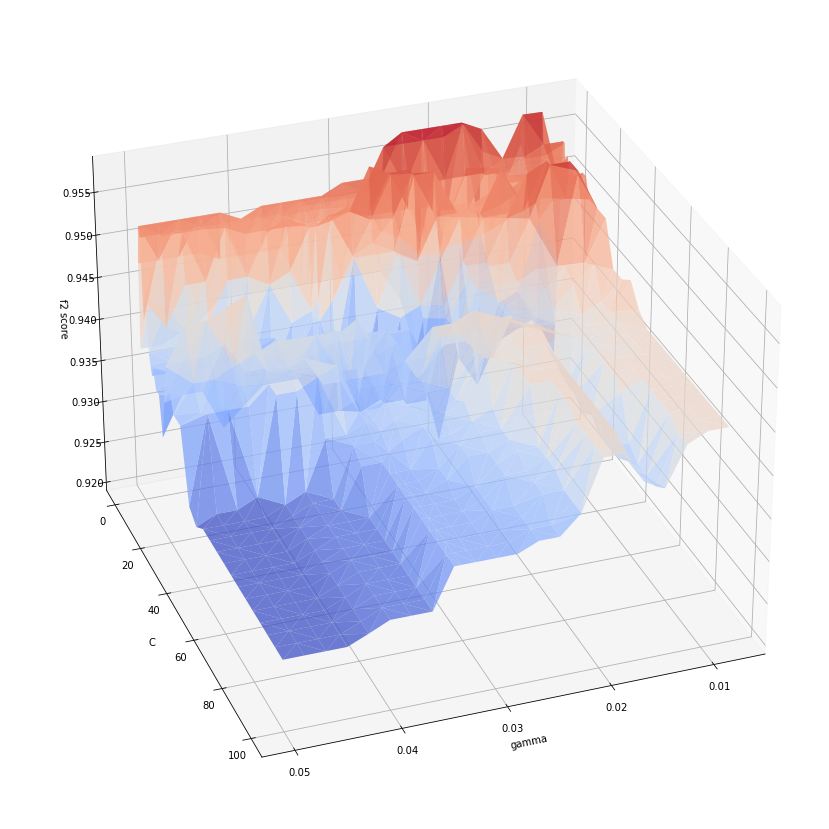

In [46]:
######################### 3D来同时看三个参数的图 #########################

# Plot the surface for f2 score
plt.figure(figsize = (15, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(results2.gamma, results2.C, results2.mean_test_f2, 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('f2 score')
ax.view_init(azim=70) #Rotation
plt.show()

The above graph shows a hypeparameter space where the combos will perform quite well in SVM model according to what we have observed before. The surface is bumpy, but it seems that a C near 10 and a gamma near 0.01 will give the best results. This will be confirmed below when we use the best combo we found.

In [51]:
######################### 用Gaussian kernel + 上面找到的最佳参数组合，测f2 #########################

# We use the best one for f2:
print(results_all_sorted2.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf2 = svm.SVC(C = results_all_sorted2.loc[0, 'C'], 
                     gamma = results_all_sorted2.loc[0, 'gamma'],
                     kernel = results_all_sorted2.loc[0, 'kernel'])
                     #random_state = 0)
svm_bestf2.fit(X_train, y_train)

y_train_pred = svm_bestf2.predict(X_train)
y_test_pred = svm_bestf2.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f2_train = f2_scorer(y_train, y_train_pred)
f2_test = f2_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of training sample: ', f2_train)
print('f2 score of test sample: ', f2_test)

C         3.000
gamma     0.012
kernel      rbf
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[165   6]
 [  0 284]]
Confusion matrix of test sample: 
 [[40  1]
 [ 0 73]]
f2 score of training sample:  0.971731448763251
f2 score of test sample:  0.9803921568627451


In [52]:
######################### 用Gaussian kernel + 上面找到的最佳参数组合，测f0.5 #########################

# We use the best one for f0.5:
print(results_all_sorted05.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf05 = svm.SVC(C = results_all_sorted05.loc[0, 'C'], 
                      gamma = results_all_sorted05.loc[0, 'gamma'],
                      kernel = results_all_sorted05.loc[0, 'kernel'],
                      random_state = 0)
svm_bestf05.fit(X_train, y_train)

y_train_pred = svm_bestf05.predict(X_train)
y_test_pred = svm_bestf05.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f05_train = f05_scorer(y_train, y_train_pred)
f05_test = f05_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f0.5 score of training sample: ', f05_train)
print('f0.5 score of test sample: ', f05_test)

C         0.50
gamma     0.01
kernel     rbf
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[158  13]
 [  0 284]]
Confusion matrix of test sample: 
 [[39  2]
 [ 0 73]]
f0.5 score of training sample:  0.983810709838107
f0.5 score of test sample:  0.9898477157360406


We get pretty descent results from both, and they produce the almost same confusion matrix. Given the simplicity of the data set and the feature of f score itself (balanced recall and precision), there is no much difference between those two objects here: maximizing f2 or f0.5.

In [53]:
######################### 最后看一下从前到后一共用了多少时间 #########################

print('It takes ' + str(round(time.time() - begin, 4)) + ' seconds to run.')

It takes 8826.5485 seconds to run.
